## Compute Sagnac Frequency - 2

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from obspy import UTCDateTime, Stream, Trace
from scipy.signal import welch, periodogram
from numpy import zeros, argmax, arange
from tqdm.notebook import tqdm
from pandas import DataFrame, read_pickle

from andbro__querrySeismoData import __querrySeismoData

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['ring'] = "U"

config['seed'] = [f"BW.DROMY..FJ{config['ring']}"]

config['tbeg'] = UTCDateTime("2022-09-19 00:00")
config['tend'] = UTCDateTime("2022-09-19 00:05")

config['outpath_data'] = "/import/kilauea-data/sagnac_frequency/"

config['path_to_sds'] = archive_path+"romy_archive/"

# config['repository'] = "george"

config['n_windows'] = 2

config['dn'] = 60
config['buffer'] = 0
config['offset'] = 30

rings = {"Z":553, "U":302, "V":448,"W":448}

config['f_expected'] = rings[config['ring']] ## Hz
config['f_band'] = 1.5  ## Hz

config['loaded_period'] = 10800  #seconds
config['NN'] = int(config['loaded_period']/config['dn'])

config['nblock'] = 300*5000
config['noverlap'] = None

In [4]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

## load Test Data

In [5]:
st = __load_romy_raw_data(config['seed'], config['tbeg'], config['tend'], config['path_to_sds'])

 -> loading BW.DROMY..FJU...


In [6]:
# st, inv = __querrySeismoData(
#                             seed_id=config['seed'],
#                             starttime=config['tbeg']-config['buffer']-2*config['offset'],
#                             endtime=config['tend']+config['buffer']+2*config['offset'],
#                             repository=config['repository'],
#                             path=None,
#                             restitute=None,
#                             detail=None,
# )

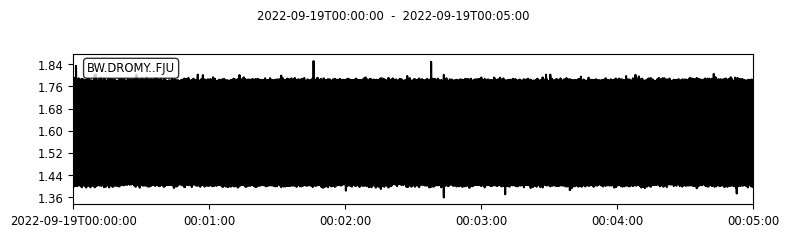

In [7]:
st.plot();

In [8]:
import multitaper.mtspec as spec

In [27]:
t, freq, qi, adap = spec.spectrogram(st[0].data, st[0].stats.delta, twin=100, olap=0.5, nw=3.5, kspec=5, fmin=250, fmax=350)

Window length 100.0s and overlap 50%
Total number of spectral estimates 5
Frequency band of interest (250.00-350.00)Hz
DPSS using interpolation 500000 100000
DPSS using interpolation 500001 100000
Total frequency points 20000
DPSS using interpolation 500001 100000
DPSS using interpolation 500001 100000
DPSS using interpolation 500001 100000
DPSS using interpolation 500001 100000


(290.0, 310.0)

(0.0, 1.0)

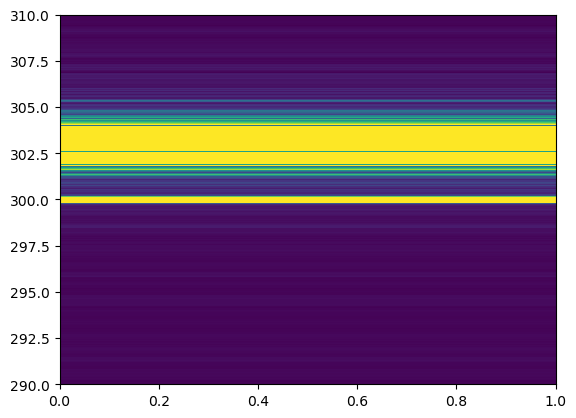

In [25]:
plt.pcolormesh(t, freq, adap, vmin=0, vmax=1e-6)
# plt.ylim(290, 310)
# plt.xlim(0, 1)

## Define Methods

In [43]:
def __makeplot(df):

    fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)

    font = 13 

    ax[0].scatter(df['times'], df['freqs'], s=10, color="r")
    ax[0].plot(df['times'], df['freqs'], "k")    

    ax[1].scatter(df['times'], df['hmhw'], s=10, color="r")
    ax[1].plot(df['times'], df['hmhw'], "k") 

    ax[2].scatter(df['times'], df['psd_max'], s=10, color="r")
    ax[2].plot(df['times'], df['psd_max'], "k") 

    hours = arange(df['times'].min(),df['times'].max()+3600,3600)

    for i in range(3):
        for hrs in hours:
            ax[i].axvline(hrs, 0, 1, zorder=0, alpha=0.4,color='grey')
    
    plt.show();

In [44]:
def __half_width_half_max(data):

    from scipy.signal import find_peaks, peak_widths
    from numpy import argmax
    
    peaks, _ = find_peaks(data)

    half = peak_widths(data, peaks, rel_height=0.5)

    idx = argmax(half[1])
    
    y, xmin, xmax = half[1][idx], half[2][idx], half[3][idx]
#     return xmin, xmax, y

    hh = abs(half[3][idx] - half[2][idx])
    
    return hh

In [45]:
def __multitaper_estimate(data, fs, n_windows=4, one_sided=True):

    from spectrum import dpss, pmtm
    from numpy import zeros, arange, linspace
    
    
    NN = len(data)
    
    ## Option 1
    #[tapers, eigen] = dpss(NN, 2.5, n_windows)
    # spectra, weights, eigenvalues = pmtm(data, e=tapers, v=eigen, show=True)

    ## Option 2
    # res = pmtm(data, NW=2.5, show=False)
    spectra, weights, eigenvalues = pmtm(data, NW=2.5, k=n_windows, show=False)

    ## average spectra
    estimate = zeros(len(spectra[0]))
    for m in range(n_windows):
        estimate += (abs(spectra[m])**2)
    estimate /= n_windows
    
    l = len(estimate)
    frequencies = linspace(-0.5*fs, 0.5*fs, l)
    
    if one_sided:
        f_tmp, psd_tmp = frequencies[int(l/2):], estimate[:int(l/2)]
    else:
        f_tmp, psd_tmp = frequencies, estimate
    
    
    f_max = f_tmp[argmax(psd_tmp)]
    p_max = max(psd_tmp)
    h_tmp = __half_width_half_max(psd_tmp)
    
    return f_tmp, f_max, p_max, h_tmp

In [46]:
def __multitaper_periodogram(data, fs, n_windows=4):

    from spectrum import dpss, pmtm
    from numpy import zeros, arange, linspace
    from scipy.signal import find_peaks, peak_widths
    
    [tapers, eigen] = dpss(len(data), 2.5, n_windows)

    f_maxima, p_maxima, hh  = zeros(n_windows), zeros(n_windows), zeros(n_windows)
    
    for ii in range(n_windows):
        
        f_tmp, psd_tmp = periodogram(data, 
                                     fs=fs, 
                                     window=tapers[:,ii], 
                                     nfft=None, 
                                     detrend='constant', 
                                     return_onesided=True, 
                                     scaling='density', 
                                     )
    
        p_maxima[ii] = max(psd_tmp)
        f_maxima[ii] = f_tmp[argmax(psd_tmp)]
       
        ## half widths
        xx = psd_tmp[argmax(psd_tmp)-10:argmax(psd_tmp)+10]
        peaks, _ = find_peaks(xx)
        half = peak_widths(xx, peaks, rel_height=0.5)
        idx = argmax(half[1]) 
        hh[ii] = abs(half[3][idx] -half[2][idx])
        
    f_mean = sum(f_maxima) / n_windows
    p_mean = sum(p_maxima) / n_windows
    h_mean = sum(hh) / n_windows
    
    return f_tmp, f_mean, p_mean, h_mean

In [47]:
def __periodogram_estimate(st_in, fs):
    
    from scipy.signal.windows import tukey
    from scipy.signal import periodogram
    from numpy import nanmean
    
    st_cp = st_in.copy()
    
    print(st_cp[0].data)
        
    tukey_win = tukey(len(st_cp[0].data))

    f_tmp, psd_tmp = periodogram(st_cp[0].data, 
                                 fs=fs, 
                                 window=tukey_win, 
                                 nfft=None, 
                                 detrend='constant', 
                                 return_onesided=True, 
                                 scaling='density', 
                                 )

    f_max = f_tmp[argmax(psd_tmp)]
    p_max = max(psd_tmp)
    h_tmp = __half_width_half_max(psd_tmp)
    
    return f_tmp, f_max, p_max, h_tmp

In [48]:
def __hilbert_frequency_estimator(config, st, fs, plot=False):

    from scipy.signal import hilbert
    import numpy as np
    
    st0 = st.copy()
    
    
    f_lower = config['f_expected'] - config['f_band']
    f_upper = config['f_expected'] + config['f_band']

    
    ## bandpass with butterworth
    st0.detrend("demean")
    st0.taper(0.1)
    st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=8, zerophase=True)
    
    
    ## estimate instantaneous frequency with hilbert
    signal = st0[0].data
    
    analytic_signal = hilbert(signal)

    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

    ## cut first and last 5% (corrupted)
    
    dd = int(0.05*len(instantaneous_frequency))
    
    t = st0[0].times()
    t1 = st0[0].times()[1:]
    t2 = t1[dd:-dd]
    
    t_mid = t[int((len(t))/2)]
    
    insta_f_cut = instantaneous_frequency[dd:-dd]
    
    ## averaging
    insta_f_cut_mean = np.mean(insta_f_cut)
#     insta_f_cut_mean = np.median(insta_f_cut)
    
    if plot:
        st0.plot(equal_scale=False);

        fig, (ax0, ax1) = plt.subplots(nrows=2)
        ax0.plot(t, signal, label='signal')
        ax0.plot(t, amplitude_envelope, label='envelope')
        ax0.set_xlabel("time in seconds")
        ax0.legend()
        ax1.plot(t2, insta_f_cut)
        ax1.set_xlabel("time in seconds")
        ax1.set_ylim(552, 555)
        fig.tight_layout()
    
    return t_mid, insta_f_cut_mean, np.mean(amplitude_envelope) ,np.std(insta_f_cut)

In [49]:
def __multitaper_hilbert(config, st, fs, n_windows, plot=False):
    
    import numpy as np

    from scipy.signal import hilbert
    from spectrum import dpss, pmtm

    N = len(st[0].data)
    
    [tapers, eigen] = dpss(N, 2.5, n_windows)

    
    f_lower = config['f_expected'] - config['f_band']
    f_upper = config['f_expected'] + config['f_band']
   

    tmp_insta_f_cut_mean = zeros(n_windows)
    tmp_amp = zeros(n_windows)
    tmp_std_dev = zeros(n_windows)
    
    for ii in range(n_windows):

        st0 = st.copy()
    
        ## bandpass with butterworth
        st0.detrend("simple")
        st0.taper(0.01)
#         st0[0].data = st0[0].data*tapers[:, ii]
        st0.filter("bandpass", freqmin=f_lower, freqmax=f_upper, corners=8, zerophase=True)
        
        
        ## estimate instantaneous frequency with hilbert
        signal = st0[0].data*tapers[:, ii]

#         plt.plot(signal)
#         plt.show();
        
        ## compute instanteous frequencies using hilbert
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

        ## cut first and last 5% (corrupted)
        dd = int(0.05*len(instantaneous_frequency))

        t = st0[0].times()
        t1 = st0[0].times()[1:]
        t2 = t1[dd:-dd]

        t_mid = t[int((len(t))/2)]
        insta_f_cut = instantaneous_frequency[dd:-dd]

        ## averaging
        tmp_insta_f_cut_mean[ii] = np.mean(insta_f_cut)
    #     insta_f_cut_mean = np.median(insta_f_cut)
        tmp_amp[ii] = np.mean(amplitude_envelope)
        tmp_std_dev[ii] = np.std(insta_f_cut)
    
    ## average for different tapers
    insta_f_cut_mean = np.sum(tmp_insta_f_cut_mean)/n_windows
    amp = np.sum(tmp_amp)/n_windows
    std_dev = np.sum(tmp_std_dev)/n_windows
    
    
    if plot:
        st0.plot(equal_scale=False);

        fig, (ax0, ax1) = plt.subplots(nrows=2)
        ax0.plot(t, signal, label='signal')
        ax0.plot(t, amplitude_envelope, label='envelope')
        ax0.set_xlabel("time in seconds")
        ax0.legend()
        ax1.plot(t2, insta_f_cut)
        ax1.set_xlabel("time in seconds")
        ax1.set_ylim(552, 555)
        fig.tight_layout()
    
    return t_mid, insta_f_cut_mean, amp, std_dev

In [50]:
def __compute(config, st0, starttime, method="hilbert"):

    from scipy.signal import find_peaks, peak_widths, welch, periodogram
    from numpy import nan, zeros

    NN = config['NN']

    ii = 0
    n1 = 0
    n2 = config['dn']

    tt, ff, hh, pp = zeros(NN), zeros(NN), zeros(NN), zeros(NN)

    while n2 <= config['loaded_period']:

#         try:

        ## cut stream to chuncks 
        st_tmp = st0.copy().trim(starttime+n1-config['buffer']-config['offset'], starttime+n1+config['dn']+config['buffer']-config['offset'])

        ## get time series from stream
        times = st_tmp[0].times(reftime=UTCDateTime("2016-01-01T00"))

        ## get sampling rate from stream
        df = st_tmp[0].stats.sampling_rate


        if method == "hilbert":

            f_tmp, f_max, p_max, h_tmp = __hilbert_frequency_estimator(config, st_tmp, df, plot=False)

        elif method == "multitaper_hilbert":

            f_tmp, f_max, p_max, h_tmp = __multitaper_hilbert(config, st_tmp, df, n_windows=config['n_windows'])

        elif method == "multitaper_periodogram":

            f_tmp, f_max, p_max, h_tmp = __multitaper_perio(st_tmp[0].data, df, n_windows=config['n_windows'])

        elif method == "periodogram":

            f_tmp, f_max, p_max, h_tmp = __periodogram_estimate(st_tmp, df)

        elif method == "multitaper":

            f_tmp, f_max, p_max, h_tmp = __multitaper_estimate(st_tmp[0].data, df, n_windows=config['n_windows'], one_sided=True)                


        ## append values to arrays
        tt[ii] = times[int(len(times)/2)]
        ff[ii] = f_max
        pp[ii] = p_max
        hh[ii] = h_tmp

#         except:
#             tt[ii], ff[ii], pp[ii], hh[ii] = nan, nan, nan, nan
#             print(" -> computing failed")

        ii += 1
        n1 += config['dn']
        n2 += config['dn']

    return tt, ff, hh, pp

## Produce Data

In [51]:
method = "multitaper_hilbert"
# method = "hilbert"

tt, ff, hh, pp = __compute(config, st, config['tbeg'], method=method)

ModuleNotFoundError: No module named 'spectrum'

In [52]:
df = DataFrame()
df['times'] = tt
df['freqs'] = ff
df['hmhw']  = hh
df['psd_max'] = pp

# df.to_pickle(config['outpath_data']+f"test_{method}_n2.pkl")

NameError: name 'tt' is not defined

## Plotting 

In [308]:
def __makeplot(df0, labels=[]):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

#         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth
    
    time_scaling, time_unit = 86400, "days"
    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 13 
    smooting = 3
    cut_off = int(smooting/2)
    
    colors = ['k', 'r', 'b', 'g', 'orange']
    
    for nn, (df, label) in enumerate(zip(df0, labels)):
    
        ax[0].scatter(df['times']/time_scaling, df['freqs'], c=colors[nn], s=10, alpha=0.4, zorder=2, label=label)
        ax[0].plot(df['times'][cut_off:-cut_off]/time_scaling, __smooth(df['freqs'],smooting)[cut_off:-cut_off], color=colors[nn], zorder=2)
    
        ax[1].scatter(df['times']/time_scaling, df['hmhw'], c=colors[nn], s=10, alpha=0.4, zorder=2)
        ax[1].plot(df['times'][cut_off:-cut_off]/time_scaling, __smooth(df['hmhw'],smooting)[cut_off:-cut_off], colors[nn], alpha=0.7, zorder=2) 
        
        ax[2].scatter(df['times']/time_scaling, df['psd_max'], c=colors[nn], s=10, alpha=0.4, zorder=2)
        ax[2].plot(df['times'][cut_off:-cut_off]/time_scaling, __smooth(df['psd_max'],smooting)[cut_off:-cut_off], colors[nn], alpha=0.7, zorder=2) 
    
    ax[2].set_yscale("log")


#     ax[0].set_ylim(553.4550, 553.4655)
#     ax[0].set_ylim(553.1, 553.5)
    
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    
    ax[0].set_ylabel(r"Sagnac Beat (Hz)", fontsize=font)
    ax[1].set_ylabel(r"Std. Dev (Hz)", fontsize=font)
    ax[2].set_ylabel(r"Mean of Envelope", fontsize=font)

    ax[2].set_xlabel("Days since 2016-01-01", fontsize=font)
    
    ax[0].set_title("ROMY Sagnac-Frequency", fontsize=font+2, pad=10)
    ax[0].legend(loc=4)
        
#     ax[0].set_xlim(2435.08, 2435.12)
        
    for i in range(3):
        ax[i].grid(zorder=0)
    
    plt.show();

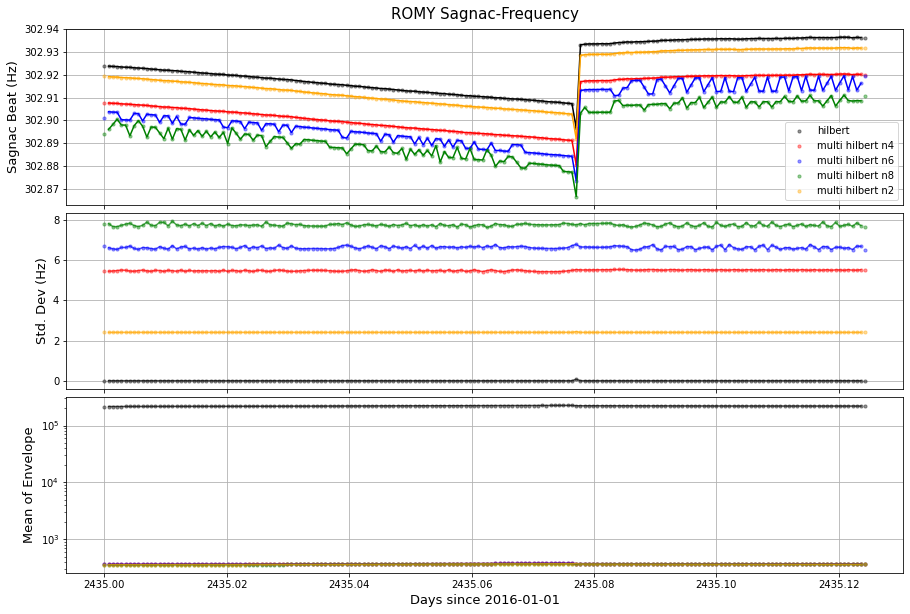

In [309]:
df0 = read_pickle(config['outpath_data']+"test_hilbert.pkl")
df1 = read_pickle(config['outpath_data']+"test_multitaper_hilbert_n4.pkl")
df2 = read_pickle(config['outpath_data']+"test_multitaper_hilbert_n6.pkl")
df3 = read_pickle(config['outpath_data']+"test_multitaper_hilbert_n8.pkl")
df4 = read_pickle(config['outpath_data']+"test_multitaper_hilbert_n2.pkl")


__makeplot([df0, df1, df2, df3, df4], labels=["hilbert","multi hilbert n4","multi hilbert n6","multi hilbert n8","multi hilbert n2"])

## Test intervall for periodogramm

In [ ]:
config['buffer'] = 0

intervals = [20, 30, 60, 120, 180, 600]

for dn in intervals:

    print(dn)
    config['dn'] = dn
    
    df = DataFrame()

#     df['times'], df['freqs'], df['hmhw'], df['psd_max'] = __compute(config, st, config['tbeg'], method="periodogram")
    df['times'], df['freqs'], df['hmhw'], df['psd_max'] = __compute2(config, st, config['tbeg'])
    
    df.to_pickle(config['outpath_data']+f"test_perio_{dn}_{config['buffer']}.pkl")

In [ ]:
def __makeplot_intervals(config, intervals):

    plt.figure(figsize=(15,5))

    font = 14

    for i, dn in enumerate(intervals):
        df = read_pickle(config['outpath_data']+f"test_perio_{dn}_{config['buffer']}.pkl")

    #     plt.scatter(df['times'], df['freqs'], label=f"perio_{dn}_{config['buffer']}")
        plt.plot((df['times']-df['times'][0])/60, df['freqs'], label=f"perio_{dn}_{config['buffer']}")

    plt.ticklabel_format(useOffset=False, style='plain')

    plt.xlabel("Time (min)", fontsize=font)
    plt.ylabel("beat note (Hz)", fontsize=font)

    plt.legend()

    plt.show();

__makeplot_intervals(config, intervals)

## Test Chrip Signal

In [ ]:
from scipy.signal import hilbert, chirp
import numpy as np

def white_noise(rho, sr, n, mu=0):
    sigma = rho * np.sqrt(sr/2)
    noise = np.random.normal(mu, sigma, n)
    return noise

duration = 1200 ## seconds
fs = 5000.0
rho = 0.005
f_min = 10
f_max = 90

samples = int(fs*duration)

t = np.arange(samples) / fs

f_theo = np.linspace(f_min, f_max, 100)
t_theo = np.linspace(t[0], t[-1], 100)

noise = white_noise(rho, fs, samples)

signal = chirp(t, f_min, t[-1], f_max) 
# signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )
signal += noise

plt.plot(t, signal, label='signal')
plt.xlim(0.5, 10)

In [ ]:
df = DataFrame()

tr = Trace()
tr.data = signal
tr.stats.sampling_rate = fs
tr.stats.starttime = config['tbeg']

st = Stream(traces=tr)

print(st)

config['buffer'] = 0
config['dn'] = 60
config['loaded_period'] = duration

df['times'], df['freqs'], df['hmhw'], df['psd_max'] = __compute(config, st, config['tbeg'], method="hilbert")
# df['times'], df['freqs'], df['hmhw'], df['psd_max'] = __compute2(config, st, config['tbeg'])
# df['times'], df['freqs'], df['hmhw'], df['psd_max'] = __compute(config, st, config['tbeg'], method="periodogram")

df.to_pickle(config['outpath_data']+f"test_perio_{config['dn']}_{config['buffer']}_chirp.pkl")

In [ ]:
def __makeplot_chirp(config):

    dn = config['dn']
    
    plt.figure(figsize=(15,5))

    font = 14
    
    df = read_pickle(config['outpath_data']+f"test_perio_{dn}_{config['buffer']}_chirp.pkl")
    ref = df['times'][0]
    df = df.loc[(df!=0).any(axis=1)]

    plt.scatter(df['times']-ref, df['freqs'], label=f"perio_{dn}_{config['buffer']}")
#     plt.plot((df['times']-df['times'][0])/60, df['freqs'], label=f"perio_{dn}_{config['buffer']}")

    plt.plot(t_theo, f_theo, 'k')
    
    plt.ticklabel_format(useOffset=False, style='plain')

    plt.xlabel("Time (min)", fontsize=font)
    plt.ylabel("beat note (Hz)", fontsize=font)

    plt.legend()

#     plt.ylim(f_min, f_max)
    
    plt.show();

__makeplot_chirp(config)

## Test Synthetic

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

"""
parameters: 
rhp - spectral noise density unit/SQRT(Hz)
sr  - sample rate
n   - no of points
mu  - mean value, optional

returns:
n points of noise signal with spectral noise density of rho
"""
def white_noise(rho, sr, n, mu=0):
    sigma = rho * np.sqrt(sr/2)
    noise = np.random.normal(mu, sigma, n)
    return noise

rho = 10
sr = 5000
n = 80000
period = n/sr
time = np.linspace(0, period, n)

signal_pure = 100*np.sin(2*np.pi*553*time)
signal_pure2 = 100*np.sin(2*np.pi*553.01*time)

noise = white_noise(rho, sr, n)
signal_with_noise = signal_pure + signal_pure2 + noise

f, psd = signal.periodogram(signal_with_noise, sr)

print("Mean spectral noise density = ",np.sqrt(np.mean(psd[50:])), "arb.u/SQRT(Hz)")

plt.plot(time, signal_with_noise)
plt.plot(time, signal_pure)
plt.xlabel("time (s)")
plt.ylabel("signal (arb.u.)")
plt.show();

plt.semilogy(f[1:], np.sqrt(psd[1:]))
plt.xlabel("frequency (Hz)")
plt.ylabel("psd (arb.u./SQRT(Hz))")
#plt.axvline(13, ls="dashed", color="g")
plt.axhline(rho, ls="dashed", color="r")
plt.show();

In [ ]:
from scipy.signal.windows import tukey

tukey_win = tukey(len(signal_with_noise))

f_tmp, psd_tmp = periodogram(signal_with_noise[:5000*], 
                 fs=sr, 
                 window=tukey_win, 
                 nfft=None, 
                 detrend='constant', 
                 return_onesided=True, 
                 scaling='density', 
                 )

plt.semilogy(f_tmp[1:], psd_tmp[1:])

plt.xlim(552., 554.)
print(max(psd_tmp), f_tmp[argmax(psd_tmp)])

## Testing Amount of Windows for Mulittaper

In [ ]:
# n1 = 300

# st_tmp = st.copy().trim(config['tbeg']+n1-config['buffer'], config['tbeg']+n1+config['dn']+config['buffer'])

# data = st_tmp[0].data
# fs = st_tmp[0].stats.sampling_rate

# fff, eee = [],[]
# for nn in [2,3,4,6,8,10]:
#     print(nn)
#     f, e = __multitaper_estimate(data, fs, n_windows=nn, one_sided=True)
     
#     fff.append(f)
#     eee.append(e)

In [ ]:
# plt.figure(figsize=(15,5))

# for i, n_win in enumerate([2,3,4,6,8,10]):
#     plt.semilogy(fff[i], eee[i], label=n_win)

# plt.legend()
# plt.xlim(553.2, 553.7)
# plt.ylim(1e10, 1e17)

# plt.xlabel("Frequency (Hz)",fontsize=13)
# plt.ylabel(r"PSD (V$^2$/Hz)",fontsize=13)
# plt.grid(zorder=0)

# plt.show();